In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from IPython.display import clear_output
import untils

[[-2.6022203   0.51525087]
 [-1.73919538  0.97137163]
 [ 0.01099801  0.0852634 ]
 [ 0.77107561 -0.66210611]] [0. 0. 1. 1.]


/tmp/ipykernel_2242570/3691543318.py:8: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  d = np.random.multivariate_normal(mean, cov, n_sample_per_class)


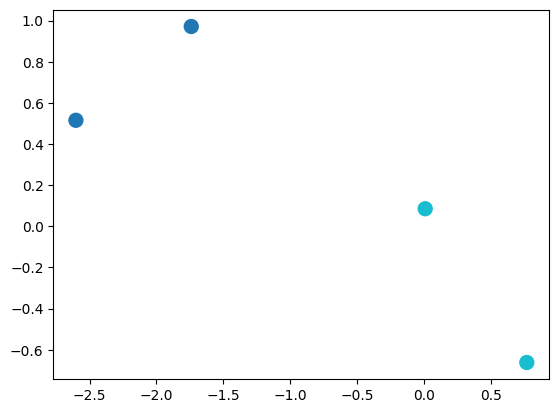

In [303]:
def gen_data(n_class, n_dim, n_sample_per_class):
    data = []
    classes = []
    for i in range(n_class):
        mean = np.random.randn(n_dim)
        # radnom covariance matrix from 0 to 1
        cov = np.random.rand(n_dim, n_dim)
        d = np.random.multivariate_normal(mean, cov, n_sample_per_class)
        
        # normalize to 0-1
        # d -= d.min()
        # d /= d.max()
        data.append(d)
        classes.append(np.ones(n_sample_per_class) * i)
    return np.concatenate(data, axis=0), np.concatenate(classes, axis=0)

# test: give 4 data points, 2 classes, 2 dimensions
data, labels = gen_data(2, 2, 2)
# plot the data, color by class
print(data, labels)
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', s=100)
plt.show()

In [252]:
step_size = 10
probs = torch.tensor([i for i in range(0, step_size+1)]) / step_size
probs

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

In [335]:
root = torch.tensor(data).mean(dim=0)

def learn_split(param: dict, data):
    data = torch.tensor(data)
    # print(data)
    root = data.mean(dim=0)

    l_probs = torch.softmax(param['l'] * 99, dim=0)
    # l_probs = param['l']
    # print('l_probs', l_probs)
    l_centroid = l_probs.unsqueeze(1) * data
    # print(l_centroid)
    l_centroid = l_centroid.sum(dim=0)
    # print(l)

    r_probs = 1 - l_probs
    r_probs = torch.softmax(r_probs * 99, dim=0)
    r_centroid = r_probs.unsqueeze(1) * data
    r_centroid = r_centroid.sum(dim=0)
    # print('root', root)
    # print('l_centroid', l_centroid)
    # print('r_centroid', r_centroid)
    # print()

    # second-level
    # ll_probs = param['ll']
    # # element-wise multiplication between ll_probs and l_probs
    # ll_probs = ll_probs * l_probs
    # ll_centroid = ll_probs.unsqueeze(1) * data
    # ll_centroid = ll_centroid.sum(dim=0)

    # lr_probs = l_probs - ll_probs
    # lr_centroid = lr_probs.unsqueeze(1) * data
    # lr_centroid = lr_centroid.sum(dim=0)

    # rl_probs = r_probs - param['rl']
    # rl_probs = rl_probs * r_probs
    # rl_centroid = rl_probs.unsqueeze(1) * data
    # rl_centroid = rl_centroid.sum(dim=0)

    # rr_probs = r_probs - rl_probs
    # rr_centroid = rr_probs.unsqueeze(1) * data
    # rr_centroid = rr_centroid.sum(dim=0)


    # loss = torch.pow(root - l_centroid, 2) + torch.pow(root - r_centroid, 2) - torch.pow(l_centroid - r_centroid, 2)
    loss = torch.pow(root - l_centroid, 2) + torch.pow(root - r_centroid, 2)
    # loss += torch.pow(l_centroid - ll_centroid, 2) + torch.pow(l_centroid - lr_centroid, 2)
    # loss += torch.pow(r_centroid - rl_centroid, 2) + torch.pow(r_centroid - rr_centroid, 2)
    loss = -loss
    loss = loss.sum()

    return loss

param = {'l': torch.tensor([1.0, 1.0, 0.0, 0.0]), 
        }
        #  'll': torch.tensor([1.0, 1.0, 1.0, 1.0]), 'rl': torch.tensor([1.0, 1.0, 1.0, 1.0])}
custom_loss = learn_split(param, data)
print(custom_loss)
# plot the centroids
# plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
# plt.scatter(centroids['root'][0], centroids['root'][1], c='red')
# plt.scatter(centroids['l'][0], centroids['l'][1], c='blue')
# plt.scatter(centroids['r'][0], centroids['r'][1], c='green')
# plt.show()
def get_target_loss(data, labels):
    data = torch.tensor(data)
    labels = torch.tensor(labels)
    data_mean = data.mean(dim=0)
    class_a_mean = data[labels == 0].mean(dim=0)
    class_b_mean = data[labels == 1].mean(dim=0)
    # class_c_mean = data[labels == 2].mean(dim=0)
    # class_d_mean = data[labels == 3].mean(dim=0)

    # class_ab_mean = (class_a_mean + class_b_mean) / 2
    # class_cd_mean = (class_d_mean + class_c_mean) / 2

    # print('data', data)
    # print('data_mean', data_mean)
    # print('class_a_mean', class_a_mean)
    # print('class_b_mean', class_b_mean)

    loss = torch.pow(data_mean - class_a_mean, 2) + torch.pow(data_mean - class_b_mean, 2) - torch.pow(class_a_mean - class_b_mean, 2)
    # loss = torch.pow(data_mean - class_ab_mean, 2) + torch.pow(data_mean - class_cd_mean, 2)
    # loss += torch.pow(class_ab_mean - class_a_mean, 2) + torch.pow(class_ab_mean - class_b_mean, 2)
    # loss += torch.pow(class_cd_mean - class_c_mean, 2) + torch.pow(class_cd_mean - class_d_mean, 2)
    loss = loss
    loss = loss.sum()
    return loss
print(get_target_loss(data, labels))
target_loss = get_target_loss(data, labels)

tensor(-3.8135, dtype=torch.float64)
tensor(-3.8135, dtype=torch.float64)


min_loss tensor(-3.9473, dtype=torch.float64)
params_at_min {'l': tensor([0.0000, 0.0000, 0.7000, 0.8000])}


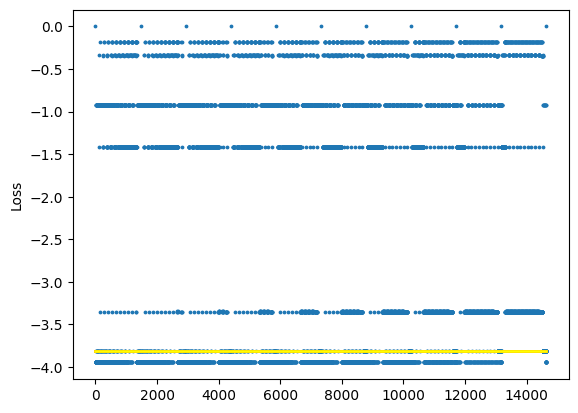

In [336]:
all_losses = []
steps = 0
params_at_min = None
min_loss = float('inf')
for a_l in probs:
    for b_l in probs:
        for c_l in probs:
            for d_l in probs:
                # for a_ll in probs:
                #     for b_ll in probs:
                #         for c_ll in probs:
                #             for d_ll in probs:
                #                 for a_rl in probs:
                #                     for b_rl in probs:
                #                         for c_rl in probs:
                #                             for d_rl in probs:                   
                param = {'l': torch.tensor([a_l, b_l, c_l, d_l]), 
                }
                        # 'll': torch.tensor([a_ll, b_ll, c_ll, d_ll]),
                        # 'rl': torch.tensor([a_rl, b_rl, c_rl, d_rl])}
                loss = learn_split(param, data)
                if loss < min_loss:
                    min_loss = loss
                    params_at_min = param
                steps += 1
                all_losses.append([steps, loss.item()])
all_losses = np.array(all_losses)
print('min_loss', min_loss)
print('params_at_min', params_at_min)

plt.scatter(all_losses[:, 0], all_losses[:, 1], s=3)
# plot the target loss as a line
plt.plot([0, steps], [target_loss, target_loss], c='red', linewidth=2)
plt.plot([0, steps], [custom_loss, custom_loss], c='yellow', linewidth=2)
plt.ylabel('Loss')
plt.show()

tensor(-2.6967, dtype=torch.float64)


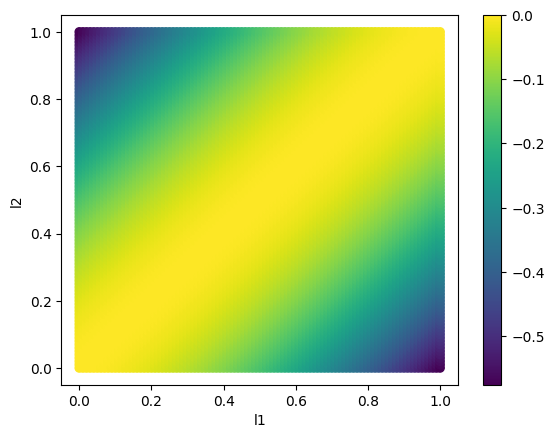

In [170]:
all_losses = []
for a_l in probs:
    for b_l in probs:
        param = {'l': torch.tensor([a_l, b_l])}
        loss = learn_split(param, data)
        all_losses.append([a_l, b_l, loss.item()])
all_losses = np.array(all_losses)
# print(all_losses)
# plot the loss contour
plt.scatter(all_losses[:, 0], all_losses[:, 1], c=all_losses[:, 2], cmap='viridis')
plt.xlabel('l1')
plt.ylabel('l2')
plt.colorbar()
# mark target loss
target_loss = get_target_loss(data, labels)
print(target_loss)
# plt.scatter(param['l'][0], param['l'][1], c='red', s=100)
plt.show()
        

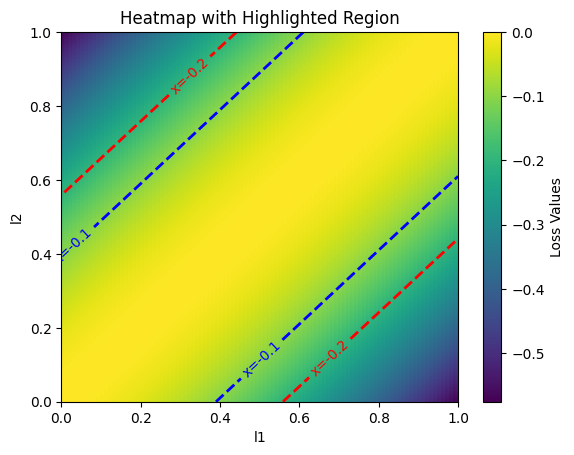

In [188]:
# Assuming `all_losses` is your data array
from scipy.interpolate import griddata  # Import griddata for interpolation

x = all_losses[:, 0]
y = all_losses[:, 1]
c = all_losses[:, 2]

# Desired value to highlight
target_value = -0.2
custom_value = -0.1

# Create the scatter plot
scatter = plt.scatter(x, y, c=c, cmap='viridis')
plt.colorbar(scatter, label='Loss Values')

# Use a contour to mark the region
# Create a grid for contouring
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xi, yi)
Z = griddata((x, y), c, (X, Y), method='linear')  # Interpolating data

# Add contour for the target value
contour_1 = plt.contour(X, Y, Z, levels=[target_value], colors='red', linewidths=2)
contour_2 = plt.contour(X, Y, Z, levels=[custom_value], colors='blue', linewidths=2)

plt.clabel(contour_1, inline=True, fontsize=10, fmt=f"x={target_value}")
plt.clabel(contour_2, inline=True, fontsize=10, fmt=f"x={custom_value}")


plt.xlabel('l1')
plt.ylabel('l2')
plt.title('Heatmap with Highlighted Region')
plt.show()